In [1]:
%pip install -qU "airavata-python-sdk[notebook]"
import airavata_jupyter_magic

%authenticate
%request_runtime hpc_gpu --file=cybershuttle.yml --walltime=60 --use=NeuroData25VC2:cloud
%wait_for_runtime hpc_gpu --live
%switch_runtime hpc_gpu

Note: you may need to restart the kernel to use updated packages.

Loaded airavata_jupyter_magic (2.1.4.post4) 
(current runtime = local)

  %authenticate                              -- Authenticate to access high-performance runtimes.
  %request_runtime <rt> [args]               -- Request a runtime named <rt> with configuration <args>.
                                                Call multiple times to request multiple runtimes.
  %restart_runtime <rt>                      -- Restart runtime <rt> if it hangs. This will clear all variables.
  %stop_runtime <rt>                         -- Stop runtime <rt> when no longer needed.
  %wait_for_runtime <rt>                     -- Wait for runtime <rt> to be ready.
  %switch_runtime <rt>                       -- Switch the active runtime to <rt>. All subsequent cells will run here.
  %%run_on <rt>                              -- Force a cell to always execute on <rt>, regardless of the active runtime.
  %stat_runtime <rt>               

Output()

Authenticated.

Requesting runtime=hpc_gpu...
[NeuroData25VC2:cloud, 60 Minutes, 1 Node(s), 1 CPU(s), 0 GPU(s), 16000 MB RAM, 1024 MB VRAM]
* modules=[]
* libraries=['python=3.10', 'pip', 'pytorch', 'pytorch-lightning', 'ase', 'scikit-learn', 'torchmetrics', 'numpy', 'wandb', 'tensorboard', 'tensorboardX', 'tqdm', 'rich', 'mattersim', 'fairchem-core', 'ipywidgets']
* pip=['nshconfig-extra', 'git+https://github.com/cyber-shuttle/mattertune.git']
* mounts=[]
Requested runtime=hpc_gpu
Request successful: runtime=hpc_gpu


Output()

local:/var/folders/_n/fcf6nx4j67gbbt4_8mjqxdc80000gn/T/connection_4uaktgm8.json --> hpc_gpu:connection_4uaktgm8.json... [200]
started proc_name=hpc_gpu_kernel on rt=hpc_gpu. pid=2106
forwarding ports=[29940, 29941, 29942, 29943, 29944]
hpc_gpu:29940 -> access via 18.118.140.230:10000
hpc_gpu:29941 -> access via 18.118.140.230:10001
hpc_gpu:29942 -> access via 18.118.140.230:10002
hpc_gpu:29943 -> access via 18.118.140.230:10003
hpc_gpu:29944 -> access via 18.118.140.230:10004
started ipykernel tunnels for hpc_gpu at 18.118.140.230
started ipykernel client for hpc_gpu
Remote Jupyter kernel launched and connected for runtime=hpc_gpu.
Switched to runtime=hpc_gpu.


In [2]:
! nvidia-smi

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
Mon May 12 09:51:04 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  GRID A100X-10C                 On  | 00000000:04:00.0 Off |                    0 |
| N/A   N/A    P0              N/A /  N/A |      1MiB / 10240MiB |      0%      Default |
|                                         |                      |             Disabled 

In [3]:
! wget https://raw.githubusercontent.com/cyber-shuttle/MatterTune/refs/heads/main/examples/water-thermodynamics/data/train_water_1000_eVAng.xyz -O train_water_1000_eVAng.xyz
! wget https://raw.githubusercontent.com/cyber-shuttle/MatterTune/refs/heads/main/examples/water-thermodynamics/data/val_water_1000_eVAng.xyz -O val_water_1000_eVAng.xyz
! wget https://raw.githubusercontent.com/cyber-shuttle/MatterTune/refs/heads/main/examples/water-thermodynamics/data/H2O.xyz -O H2O.xyz
! wget https://raw.githubusercontent.com/cyber-shuttle/MatterTune/refs/heads/main/examples/water-thermodynamics/data/water_1000_eVAng-energy_reference.json -O water_1000_eVAng-energy_reference.json

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
--2025-05-12 09:51:05--  https://raw.githubusercontent.com/cyber-shuttle/MatterTune/refs/heads/main/examples/water-thermodynamics/data/train_water_1000_eVAng.xyz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27217993 (26M) [text/plain]
Saving to: ‘train_water_1000_eVAng.xyz’

train_water_1000_eV 100%[===================>]  25.96M  --.-KB/s    in 0.1s    

2025-05-12 09:51:09 (244 MB/s) - ‘train_water_1000_eVAng.xyz’ saved [27217993/27217993]

--2025-05-12 09:51:09--  https://raw.githubusercontent.com/cyber-shuttle/MatterTune/refs/heads/main/examples/water-thermodynamics/data/val_water_1000_eVAng.xyz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.1

In [4]:
from __future__ import annotations

import logging
from pathlib import Path
import rich
import nshutils as nu
import nshconfig as C
import nshconfig_extra as CE

from ase.io import read
from ase import Atoms
import numpy as np
import torch
from tqdm import tqdm

import mattertune.configs as MC
from mattertune import MatterTuner
from mattertune.backbones import (
    MatterSimM3GNetBackboneModule,
    JMPBackboneModule,
    ORBBackboneModule,
    EqV2BackboneModule,
)

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
cell finished on hpc_gpu.


In [5]:
def fine_tune(args_dict: dict):
    """
    Fine-tune a Pre-trained Atomistic Foundation Model using MatterTuner.
    - args_dict: Dictionary containing hyperparameters and configurations for fine-tuning.
    """
    def hparams():
        hparams = MC.MatterTunerConfig.draft()

        ## Choose Backbone Model type
        if args_dict["model_type"] == "mattersim-1m":
            hparams.model = MC.MatterSimBackboneConfig.draft()
            hparams.model.graph_convertor = MC.MatterSimGraphConvertorConfig.draft()
            hparams.model.pretrained_model = "MatterSim-v1.0.0-1M"
        elif args_dict["model_type"] == "jmp-s":
            hparams.model = MC.JMPBackboneConfig.draft()
            hparams.model.graph_computer = MC.JMPGraphComputerConfig.draft()
            hparams.model.graph_computer.pbc = True
            hparams.model.pretrained_model = "jmp-s"
        elif "orb" in args_dict["model_type"]:
            hparams.model = MC.ORBBackboneConfig.draft()
            hparams.model.pretrained_model = args_dict["model_type"]
        elif args_dict["model_type"] == "eqv2":
            hparams.model = MC.EqV2BackboneConfig.draft()
            hparams.model.checkpoint_path = CE.CachedPathConfig(uri="hf://facebook/OMAT24/eqV2_31M_mp.pt").resolve()
            hparams.model.atoms_to_graph = MC.FAIRChemAtomsToGraphSystemConfig.draft()
            hparams.model.atoms_to_graph.radius = 8.0
            hparams.model.atoms_to_graph.max_num_neighbors = 20
        else:
            raise ValueError(
                "Invalid model type, please choose from ['mattersim-1m', 'jmp-s', 'orb-v2']"
            )
        hparams.model.reset_output_heads = True

        ## Set Hyperparameters of optimizer and scheduler
        hparams.model.optimizer = MC.AdamWConfig(
            lr=args_dict["lr"],
            amsgrad=False,
            betas=(0.9, 0.95),
            eps=1.0e-8,
            weight_decay=0.1,
        )
        hparams.model.lr_scheduler = MC.ReduceOnPlateauConfig(
            mode="min",
            monitor=f"val/forces_mae",
            factor=0.8,
            patience=5,
            min_lr=1e-8,
        )
        hparams.trainer.ema = MC.EMAConfig(decay=0.99)

        # Add model properties, these are the properties to be predicted by the model
        hparams.model.properties = []
        energy_coefficient = 1.0
        conservative = args_dict["conservative"] or "mattersim" in args_dict["model_type"]
        energy = MC.EnergyPropertyConfig(
            loss=MC.MSELossConfig(), loss_coefficient=energy_coefficient
        )
        hparams.model.properties.append(energy)
        forces = MC.ForcesPropertyConfig(
            loss=MC.MSELossConfig(), conservative=conservative, loss_coefficient=1.0
        )
        hparams.model.properties.append(forces)

        ## Set Data Module to load the dataset
        ## Here we downsampled 30 data points from the original training set because it's already enough
        hparams.data = MC.ManualSplitDataModuleConfig.draft()
        hparams.data.train = MC.XYZDatasetConfig.draft()
        hparams.data.train.src = "./train_water_1000_eVAng.xyz"
        hparams.data.train.down_sample = 30
        hparams.data.train.down_sample_refill = True ### Although we only used 30 samples, we repeate them to reach the original dataset size
        hparams.data.validation = MC.XYZDatasetConfig.draft()
        hparams.data.validation.src = "./val_water_1000_eVAng.xyz"
        hparams.data.batch_size = args_dict["batch_size"]
        hparams.data.num_workers = 0

        ## Normalization usually helps with training stability and convergence
        ## Here we normalize the energy firstly by linear referencing and then divide by number of atoms
        hparams.model.normalizers = {
            "energy": [
                MC.PerAtomReferencingNormalizerConfig(
                    per_atom_references=Path("./water_1000_eVAng-energy_reference.json")
                ),
                MC.PerAtomNormalizerConfig(),
            ]
        }

        ## Trainer Hyperparameters, used to configure number of epochs, devices, etc.
        hparams.trainer = MC.TrainerConfig.draft()
        hparams.trainer.max_epochs = args_dict["max_epochs"]
        hparams.trainer.accelerator = "gpu"
        hparams.trainer.devices = args_dict["devices"]
        hparams.trainer.gradient_clip_algorithm = "norm"
        hparams.trainer.gradient_clip_val = 1.0
        hparams.trainer.precision = "32"

        ## Configure Early Stopping
        hparams.trainer.early_stopping = MC.EarlyStoppingConfig(
            monitor=f"val/forces_mae", patience=50, mode="min"
        )

        ## Configure Model Checkpoint
        hparams.trainer.checkpoint = MC.ModelCheckpointConfig(
            monitor="val/forces_mae",
            dirpath="./checkpoints",
            filename=f"{args_dict['model_type']}-best",
            save_top_k=1,
            mode="min",
        )

        ## Configure Logger
        hparams.trainer.loggers = [
            MC.TensorBoardLoggerConfig(
                save_dir="./logs",
                name=f"{args_dict['model_type']}-tune",
                version=0,
            ),
        ]

        ## Additional trainer settings
        ## Here since mattersim models are conservative, we set inference_mode to False to enable differentiable energy prediction
        from lightning.pytorch.callbacks import RichProgressBar
        hparams.trainer.additional_trainer_kwargs = {
            "inference_mode": False,
            "callbacks": [RichProgressBar()],
        }


        hparams = hparams.finalize(strict=False)
        return hparams

    mt_config = hparams()
    model, trainer = MatterTuner(mt_config).tune()


executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
cell finished on hpc_gpu.


In [6]:
def inference(args_dict: dict):
    """
    Perform inference using the fine-tuned model on the validation dataset.
    Load the fine-tuned model from the checkpoint using .load_from_checkpoint function.
    Convert the loaded model to an ASE calculator using the `ase_calculator` method.
    Evaluate the model on the validation dataset and compute the MAE for energies and forces.
    """

    ckpt_path = f"./checkpoints/{args_dict['model_type']}-best.ckpt"
    if "mattersim" in args_dict["model_type"]:
        ft_model = MatterSimM3GNetBackboneModule.load_from_checkpoint(ckpt_path)
    elif "jmp" in args_dict["model_type"]:
        ft_model = JMPBackboneModule.load_from_checkpoint(ckpt_path)
    elif "orb" in args_dict["model_type"]:
        ft_model = ORBBackboneModule.load_from_checkpoint(ckpt_path)
    elif "eqv2" in args_dict["model_type"]:
        ft_model = EqV2BackboneModule.load_from_checkpoint(ckpt_path)
    else:
        raise ValueError(
            "Invalid model type, please choose from ['mattersim-1m', 'jmp-s', 'orb-v2', 'eqv2']"
        )

    val_atoms_list:list[Atoms] = read("./val_water_1000_eVAng.xyz", ":") # type: ignore
    calc = ft_model.ase_calculator(
        device = f"cuda:{args_dict['devices'][0]}"
    )
    energies_per_atom = []
    forces = []
    pred_energies_per_atom = []
    pred_forces = []
    for atoms in tqdm(val_atoms_list):
        energies_per_atom.append(atoms.get_potential_energy() / len(atoms))
        forces.extend(np.array(atoms.get_forces()).tolist())
        atoms.set_calculator(calc)
        pred_energies_per_atom.append(atoms.get_potential_energy() / len(atoms))
        pred_forces.extend(np.array(atoms.get_forces()).tolist())

    e_mae = torch.nn.L1Loss()(torch.tensor(energies_per_atom), torch.tensor(pred_energies_per_atom))
    f_mae = torch.nn.L1Loss()(torch.tensor(forces), torch.tensor(pred_forces))

    rich.print(f"Energy MAE: {e_mae} eV/atom")
    rich.print(f"Forces MAE: {f_mae} eV/Ang")

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
cell finished on hpc_gpu.


In [7]:
## We support various logging methods, including TensorBoard, WandB, and CSV files.
## In this demo we used TensorBoard, so we can visualize the training process using TensorBoard.
## Below is a script to visualize the training loss using TensorBoard logs.

def visualize_tensorboard_logs(metric_name: str, unit: str):
    from tensorboard.backend.event_processing import event_accumulator
    import matplotlib.pyplot as plt

    print("Step 1")
    # Read the event file
    ea = event_accumulator.EventAccumulator("./logs/mattersim-1m-tune/version_0")
    print("Step 2")
    ea.Reload()

    print("Step 3")
    # Check what scalar tags are available
    print(ea.Tags()["scalars"])

    print("Step 4")

    # For example, we export the 'loss' curve
    scalar_events = ea.Scalars(metric_name)
    steps = [e.step for e in scalar_events]
    values = [e.value for e in scalar_events]

    # Plotting
    plt.plot(steps, values)
    plt.xlabel("Step")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} ({unit}) over steps")
    plt.show()

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
cell finished on hpc_gpu.


In [8]:
! ls

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
A112892744		  job_1002407625.slurm
AiravataAgent.stderr	  kernel.py
AiravataAgent.stdout	  micromamba
H2O.xyz			  train_water_1000_eVAng.xyz
airavata-agent		  val_water_1000_eVAng.xyz
application		  water_1000_eVAng-energy_reference.json
connection_4uaktgm8.json
cell finished on hpc_gpu.


In [9]:
configs = {
    "model_type": "mattersim-1m",
    "conservative": True,
    "batch_size": 2,
    "max_epochs": 2,
    "lr": 8e-5,
    "devices": [0],
}
fine_tune(configs)

Epoch 1/1  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450/450 0:01:10 • 0:00:00 6.42it/s v_num: 0.000

`Trainer.fit` stopped: `max_epochs=2` reached.


cell finished on hpc_gpu.


executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...
Step 1
Step 2
Step 3
['hp_metric', 'train/energy_loss', 'train/forces_loss', 'train/total_loss', 'train/energy_mae_step', 'train/energy_mse_step', 'train/energy_rmse_step', 'train/forces_mae_step', 'train/forces_mse_step', 'train/forces_rmse_step', 'lr', 'epoch', 'val/energy_loss', 'val/forces_loss', 'val/total_loss', 'val/energy_mae', 'val/energy_mse', 'val/energy_rmse', 'val/forces_mae', 'val/forces_mse', 'val/forces_rmse', 'train/energy_mae_epoch', 'train/energy_mse_epoch', 'train/energy_rmse_epoch', 'train/forces_mae_epoch', 'train/forces_mse_epoch', 'train/forces_rmse_epoch']
Step 4


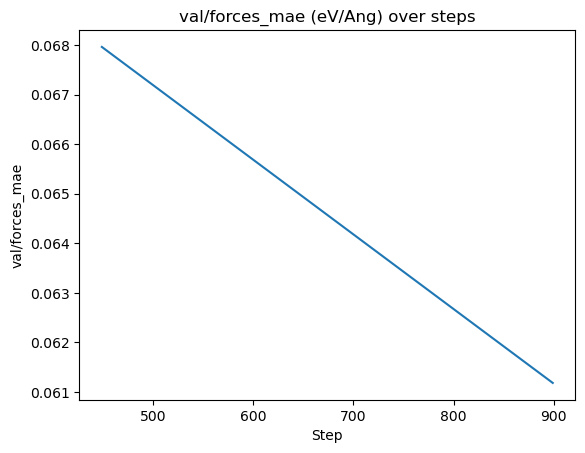

cell finished on hpc_gpu.


In [10]:
visualize_tensorboard_logs("val/forces_mae", unit="eV/Ang")

In [11]:
inference(configs)

executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...


  0%|          | 0/100 [00:00<?, ?it/s]/home/exouser/cybershuttle/scratch/tmp/ipykernel_2108/185371620.py:34: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(calc)
100%|██████████| 100/100 [00:11<00:00,  8.73it/s]


Energy MAE: 0.009635365804036268 eV/atom

Forces MAE: 0.061180513352155685 eV/Ang

cell finished on hpc_gpu.


executing cell on hpc_gpu...
waiting for cell to finish on hpc_gpu...


MD Simulation Steps (Temperature: 39.07 K/300.00 K):  99%|█████████▉| 99/100 [00:05<00:00, 20.25it/s]

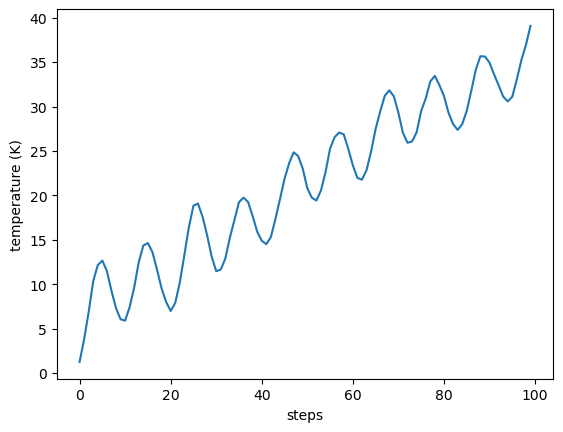

cell finished on hpc_gpu.


In [12]:
## Further we can use the fine-tuned model to run Molecular Dynamics (MD) simulations.
from ase.md.langevin import Langevin
import ase.units as units
import matplotlib.pyplot as plt

atoms:Atoms = read("./H2O.xyz")  # type: ignore
atoms.pbc = True
ft_model = MatterSimM3GNetBackboneModule.load_from_checkpoint("./checkpoints/mattersim-1m-best.ckpt")
calc = ft_model.ase_calculator()
atoms.calc = calc

dyn = Langevin(
    atoms,
    temperature_K=300,
    timestep=0.5 * units.fs,
    friction=0.02,
)
pbar = tqdm(total=100, desc="MD Simulation Steps")
temperatures = []
for step in range(100):
    dyn.step()
    temp = atoms.get_temperature()
    pbar.set_description(f"MD Simulation Steps (Temperature: {temp:.2f} K/{300:.2f} K)")
    pbar.update(1)
    temperatures.append(temp)

plt.plot(temperatures)
plt.xlabel("steps")
plt.ylabel("temperature (K)")
plt.show()

In [13]:
%stop_runtime hpc_gpu

Terminated runtime=hpc_gpu. state={'experimentId': 'CS_Agent_e79e5978-a1f4-4e68-90ab-884bd7409525', 'terminated': True}
